In [1]:
# !pip install tqdm==4.28.1
# !pip install -U gast==0.2.2
# !pip install gdown

# !gdown https://drive.google.com/uc?id=14CB3Vw4jPf-8-DAriB9XDq4mfbs4o747
# !mkdir datasets
# !tar -C datasets -xzf airport-alunos.tgz


In [2]:
import random

#%tensorflow_version 2.x
import tensorflow as tf; print(tf.__version__)
import tensorflow.keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


from sklearn.datasets import load_sample_image;
from sklearn.manifold import TSNE


import seaborn as sns


import numpy as np
import tqdm; print(tqdm.__version__)
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

2.0.0
4.28.1


In [3]:
def scatter(x, labels, subtitle='None'):
    # We choose a color palette with seaborn.
    palette_size = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", palette_size))
    
    color_map = dict({})
    color_count = 0
    for l in labels:
        if l not in color_map:
            color_map[l] = color_count
            color_count = color_count + 1
    
    def get_color_idx(label):
        return color_map[label]
        
    def get_colores_idx(labels_):
        return np.array([get_color_idx(l) for l in labels_])
        
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[get_colores_idx(labels)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for l, i in zip(labels, range(len(labels))):
        # Position of each label.
        xtext, ytext = np.median(x[labels == l, :], axis=0)
        txt = ax.text(xtext, ytext, labels[i], fontsize=16, 
                      color = palette[get_color_idx(l)]) #, bbox=dict(alpha=0.5))
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="yellow"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [4]:
def create_base_model(input_shape):
    input_layer = Input(shape = input_shape)
    
    model = Conv2D(8, (3, 3), activation = None, padding='same')(input_layer)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Conv2D(16, (3, 3), activation = None, padding='same')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Conv2D(32, (3, 3), activation = None, padding='same')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Conv2D(64, (3, 3), activation = None, padding='same')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Flatten()(model)
    model = Dense(64, activation='relu')(model)
    
    model = Model(inputs=input_layer, outputs=model)
    
    return model

### Defining S1 with TripletLoss

In [5]:
class TripletLossLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(TripletLossLayer, self).__init__()
    
    def euclidean_distance(self, vects):
        x, y = vects
        x = tf.cast(x, 'float32')
        y = tf.cast(y, 'float32')

        return K.mean(K.sum(K.square(x-y),axis=1))
    
    def call(self, inputs=None):
        #     Calcule triplet loss 
        #     loss = max(dist(a, p) - dist(a, n) + margin, 0)
        self.margin = tf.constant(0.8 , dtype='float32')
        a, p, n = inputs
        a = tf.cast(a, 'float32')
        p = tf.cast(p, 'float32')
        n = tf.cast(n, 'float32')
        
        # Calcule triplet loss 
        subt_ = tf.subtract(self.euclidean_distance([a, p]) , self.euclidean_distance([a, n]))
        sum_ = tf.add(subt_, self.margin)
        
        loss = K.maximum(sum_, 0.0)
        # add in model loss
        self.add_loss(loss)
    
        return a

In [6]:
# input_shape = (28, 28, 1)
input_shape = (128, 64, 3)
base_network = create_base_model(input_shape)

input_anchor = Input(shape=input_shape)
input_positive = Input(shape=input_shape)
input_negative = Input(shape=input_shape)

processed_a = base_network(input_anchor)
processed_p = base_network(input_positive)
processed_n = base_network(input_negative)

# loss = Lambda(triplet_loss)([processed_a, processed_p, processed_n])
loss_layer = TripletLossLayer()([processed_a, processed_p, processed_n])

model = Model([input_anchor, input_positive, input_negative], loss_layer)
adam = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=adam, loss=(lambda y_true, ypred: 0.0))

embs_model = base_network
embs_model.compile(loss=(lambda y_true, ypred: 0.0))

model.summary()
tf.keras.utils.plot_model(model)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 64)           156144      input_2[0][0]                    
                                                                 input_3[0][0]              

## Experiments with MNIST

In [16]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
x_train = x_train.reshape((60000, 28, 28, 1)).astype('float')

### Show TSNE Before Training

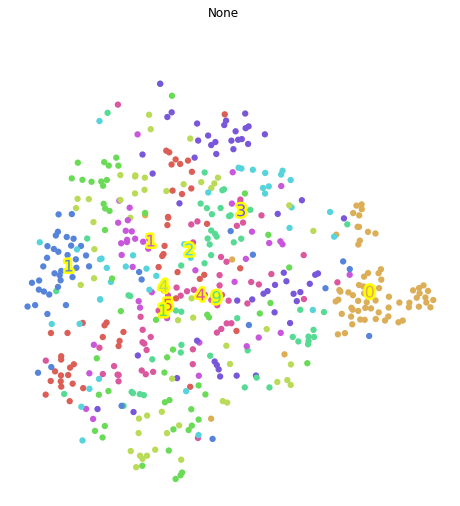

In [10]:
embs = embs_model.predict(x_train[:512])
labels = y_train[:512]
embs_2d = TSNE().fit_transform(embs)
scatter(embs_2d, labels)

In [17]:
def create_triplets(num_batches, batch_size):
    for _ in range(num_batches):
#     while True:
        batch = []
        clazz = []
        for _ in range(batch_size):
            grps_number = [1, 2, 3, 4, 5 ,6, 7, 8, 9, 0]
            
            grp = random.choice(grps_number)
            grps_number.remove(grp)
            img_a = x_train[y_train==grp][np.random.randint(x_train[y_train==grp].shape[0])]
            img_p = x_train[y_train==grp][np.random.randint(x_train[y_train==grp].shape[0])]
            
            grp_2 = random.choice(grps_number)
            img_n = x_train[y_train==grp_2][np.random.randint(x_train[y_train==grp_2].shape[0])]
            
            batch.append([img_a, img_p, img_n])
        out = np.array(batch)
        yield [out[:, i] for i in range(3)]

In [24]:
for inp_ in create_triplets(3000, 4):
    print(np.array(inp_).shape)
    break

(3, 4, 28, 28, 1)


In [23]:
print(np.array(X_train).shape)

(512, 3, 128, 64, 3)


In [12]:
batch_size = 64
y_true = np.array([[0.0 for _ in range(64)] for _ in range(batch_size)])


early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0,
                                                         verbose=0, restore_best_weights=True)

for inp_ in create_triplets(3000, batch_size):
    model.fit(inp_ , y_true, batch_size=5, epochs=1000000, callbacks=[early_stopping], shuffle=True, validation_split=0.5)

Train on 32 samples, validate on 32 samples
Epoch 1/1000000
32/32 [==============================] - 8s 249ms/sample - loss: 0.7618 - val_loss: 0.0376
Epoch 2/1000000
32/32 [==============================] - 0s 7ms/sample - loss: 0.0000e+00 - val_loss: 0.0555
Epoch 3/1000000
32/32 [==============================] - 0s 5ms/sample - loss: 0.0000e+00 - val_loss: 0.0522
Epoch 4/1000000
32/32 [==============================] - 0s 4ms/sample - loss: 0.3959 - val_loss: 0.0000e+00
Epoch 5/1000000
32/32 [==============================] - 0s 3ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/1000000
32/32 [==============================] - 0s 3ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/1000000
32/32 [==============================] - 0s 3ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/1000000
32/32 [==============================] - 0s 3ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/1000000
32/32 [==============================] - 0s 4ms/sample

KeyboardInterrupt: 

### Show TSNE After Training

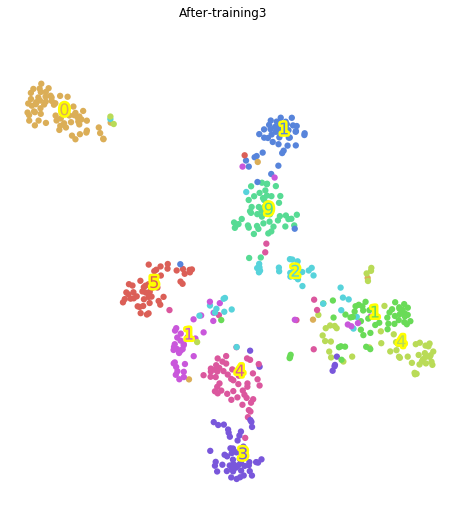

In [13]:
embs = embs_model.predict(x_train[:512])
labels = y_train[:512]
embs_2d = TSNE().fit_transform(embs)
scatter(embs_2d, labels, subtitle="After-training3")

## Experiments With Real Dataset

In [7]:
from tripplet_data import data_generator

X_train, Y_train = data_generator('datasets/airport-alunos/treino/', 50000)
X_val, Y_val = data_generator('datasets/airport-alunos/val/', 1000)

model.load_weights('weights.h5')

2.0.0


(3, 50000, 128, 64, 3)
(50000, 2)
(3, 1000, 128, 64, 3)
(1000, 2)


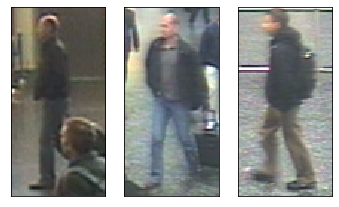

In [8]:
print(np.array(X_train).shape)
print(Y_train.shape)
print(np.array(X_val).shape)
print(Y_val.shape)

from dataset_utils import show_side_by_side
show_side_by_side(np.array([X_train[i][0] for i in range(3)]))

### Show TSNE Before Training

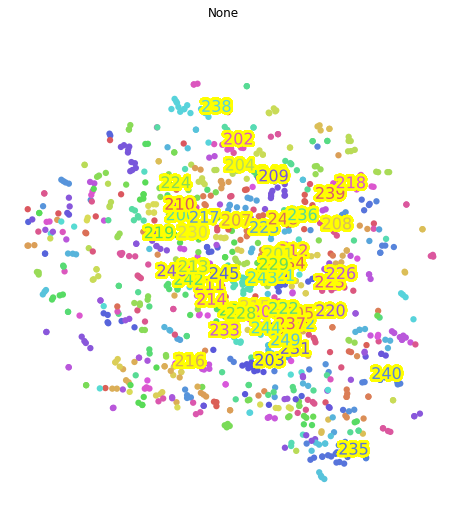

In [9]:
embs = embs_model.predict(X_val)
labels = Y_val[:, 0].astype(int)

embs_2d = TSNE().fit_transform(embs)
scatter(embs_2d, labels)

In [12]:
y_true = np.array([[0.0 for _ in range(64)] for _ in range(np.array(X_train).shape[1])])
y_true_val = np.array([[0.0 for _ in range(64)] for _ in range(np.array(X_val).shape[1])])

early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0,
                                                         verbose=0, restore_best_weights=True)

for i in range(10000):
    model.fit(X_train, y_true, batch_size=16, epochs=20000000 , shuffle=True, callbacks=[early_stopping],
              validation_data=[X_val, y_true_val])
    
    model.save_weights('weights.h5')

    X_train, Y_train = data_generator('datasets/airport-alunos/treino/', 50000)
    X_val, Y_val = data_generator('datasets/airport-alunos/val/', 1000)

Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [==============================] - 38s 763us/sample - loss: 0.0589 - val_loss: 0.1747
Epoch 2/20000000
50000/50000 [==============================] - 36s 723us/sample - loss: 0.0161 - val_loss: 0.0812
Epoch 3/20000000
50000/50000 [==============================] - 36s 719us/sample - loss: 0.0118 - val_loss: 0.1138
Epoch 4/20000000
50000/50000 [==============================] - 36s 723us/sample - loss: 0.0024 - val_loss: 0.0835
Epoch 5/20000000
50000/50000 [==============================] - 36s 720us/sample - loss: 0.0027 - val_loss: 0.0602
Epoch 6/20000000
50000/50000 [==============================] - 36s 717us/sample - loss: 9.6149e-04 - val_loss: 0.0397
Epoch 7/20000000
50000/50000 [==============================] - 36s 714us/sample - loss: 8.9784e-04 - val_loss: 0.0361
Epoch 8/20000000
50000/50000 [==============================] - 36s 722us/sample - loss: 0.0024 - val_loss: 0.0125
Epoch 9/20000000
50000/

50000/50000 [==============================] - 36s 711us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20000000
50000/50000 [==============================] - 36s 720us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/20000000
50000/50000 [==============================] - 36s 722us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
50000/50000 [==============================] - 35s 707us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 715us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [==============================] - 35s 701us/sample - loss: 2.3797e-04 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [==============================] - 35s 708us/sample - loss: 0.0010 - val_loss: 0.0000e+00
Epoch 3/20000000
50000/50000 [==============================] - 36s 712us/sample - loss: 0.0019 - val_loss: 0.0

50000/50000 [==============================] - 35s 700us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [==============================] - 36s 712us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20000000
50000/50000 [==============================] - 36s 713us/sample - loss: 9.6482e-04 - val_loss: 0.0000e+00
Epoch 4/20000000
50000/50000 [==============================] - 36s 718us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
50000/50000 [==============================] - 36s 720us/sample - loss: 2.9423e-04 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 712us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [==============================] - 35s 708us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [==============================] - 36s 722us/sample - loss: 0.0000e+00 - val_l

50000/50000 [==============================] - 36s 723us/sample - loss: 9.5946e-04 - val_loss: 0.0000e+00
Epoch 9/20000000
50000/50000 [==============================] - 36s 721us/sample - loss: 0.0012 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [==============================] - 36s 715us/sample - loss: 6.8338e-04 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [==============================] - 36s 723us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20000000
50000/50000 [==============================] - 36s 717us/sample - loss: 1.2584e-05 - val_loss: 0.0000e+00
Epoch 4/20000000
50000/50000 [==============================] - 36s 721us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
50000/50000 [==============================] - 36s 723us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 714us/sample - loss: 0.0000e+00 - val_loss:

Epoch 3/20000000
50000/50000 [==============================] - 36s 715us/sample - loss: 1.4911e-04 - val_loss: 0.0000e+00
Epoch 4/20000000
50000/50000 [==============================] - 36s 719us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
50000/50000 [==============================] - 36s 724us/sample - loss: 4.6501e-04 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 723us/sample - loss: 6.0425e-04 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [==============================] - 36s 713us/sample - loss: 0.0013 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [==============================] - 36s 723us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20000000
50000/50000 [==============================] - 36s 720us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/20000000
50000/50000 [==============================] - 36s 720us/sample - loss: 0.001

50000/50000 [==============================] - 36s 725us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
50000/50000 [==============================] - 36s 720us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 722us/sample - loss: 0.0012 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [==============================] - 36s 715us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [==============================] - 36s 721us/sample - loss: 1.1916e-04 - val_loss: 0.0000e+00
Epoch 3/20000000
50000/50000 [==============================] - 36s 723us/sample - loss: 8.1476e-04 - val_loss: 0.0000e+00
Epoch 4/20000000
50000/50000 [==============================] - 36s 711us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
50000/50000 [==============================] - 36s 715us/sample - loss: 0.0000e+00 - val_loss:

50000/50000 [==============================] - 36s 719us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [==============================] - 36s 719us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20000000
50000/50000 [==============================] - 36s 724us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/20000000
50000/50000 [==============================] - 36s 725us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
50000/50000 [==============================] - 36s 722us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 717us/sample - loss: 1.6184e-04 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [==============================] - 36s 719us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [==============================] - 36s 720us/sample - loss: 0.0000e+00 - val_l

50000/50000 [==============================] - 36s 724us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/20000000
50000/50000 [==============================] - 36s 724us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
50000/50000 [==============================] - 36s 722us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 722us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [==============================] - 36s 719us/sample - loss: 4.7138e-04 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [==============================] - 36s 724us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20000000
50000/50000 [==============================] - 36s 716us/sample - loss: 6.1393e-04 - val_loss: 0.0000e+00
Epoch 4/20000000
50000/50000 [==============================] - 36s 710us/sample - loss: 0.0000e+00 - val_l

50000/50000 [==============================] - 35s 709us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [==============================] - 36s 719us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [==============================] - 36s 724us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20000000
50000/50000 [==============================] - 36s 719us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/20000000
50000/50000 [==============================] - 36s 719us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
50000/50000 [==============================] - 36s 723us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 720us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [============================

Epoch 6/20000000
50000/50000 [==============================] - 36s 719us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [==============================] - 36s 717us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [==============================] - 36s 710us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20000000
50000/50000 [==============================] - 36s 715us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/20000000
50000/50000 [==============================] - 36s 714us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
50000/50000 [==============================] - 36s 714us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 712us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [===========

Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [==============================] - 35s 708us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [==============================] - 36s 721us/sample - loss: 4.4548e-04 - val_loss: 0.0000e+00
Epoch 3/20000000
50000/50000 [==============================] - 36s 721us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/20000000
50000/50000 [==============================] - 36s 720us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
50000/50000 [==============================] - 36s 715us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 717us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [==============================] - 36s 713us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [===========

50000/50000 [==============================] - 36s 722us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
50000/50000 [==============================] - 36s 720us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 720us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/20000000
50000/50000 [==============================] - 36s 717us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [==============================] - 35s 703us/sample - loss: 6.7182e-04 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [==============================] - 36s 715us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20000000
50000/50000 [==============================] - 36s 714us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/20000000
50000/50000 [==============================] - 36s 716us/sample - loss: 0.0000e+00 - val_l

Epoch 5/20000000
50000/50000 [==============================] - 36s 718us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 717us/sample - loss: 0.0014 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [==============================] - 36s 712us/sample - loss: 2.1034e-04 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [==============================] - 36s 719us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20000000
50000/50000 [==============================] - 36s 718us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/20000000
50000/50000 [==============================] - 36s 717us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
50000/50000 [==============================] - 36s 724us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 724us/sample - loss: 0.000

50000/50000 [==============================] - 36s 716us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
50000/50000 [==============================] - 36s 716us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 722us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [==============================] - 36s 719us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [==============================] - 36s 721us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20000000
50000/50000 [==============================] - 36s 718us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/20000000
50000/50000 [==============================] - 36s 714us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
50000/50000 [==============================] - 36s 712us/sample - loss: 0.0000e+00 - val_l

Epoch 5/20000000
50000/50000 [==============================] - 36s 717us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 715us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [==============================] - 36s 710us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [==============================] - 35s 703us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20000000
50000/50000 [==============================] - 36s 712us/sample - loss: 9.3876e-04 - val_loss: 0.0000e+00
Epoch 4/20000000
50000/50000 [==============================] - 35s 709us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
50000/50000 [==============================] - 36s 722us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 720us/sample - loss: 0

50000/50000 [==============================] - 35s 702us/sample - loss: 5.9022e-05 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [==============================] - 36s 720us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20000000
50000/50000 [==============================] - 36s 716us/sample - loss: 4.8366e-04 - val_loss: 0.0000e+00
Epoch 4/20000000
50000/50000 [==============================] - 36s 721us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
50000/50000 [==============================] - 35s 710us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 721us/sample - loss: 4.0084e-04 - val_loss: 0.0000e+00
Epoch 7/20000000
50000/50000 [==============================] - 36s 724us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [==============================] - 36s 724us/sample - loss: 0.0000e+00 - val_l

50000/50000 [==============================] - 36s 721us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [==============================] - 36s 715us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [==============================] - 35s 709us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20000000
50000/50000 [==============================] - 36s 715us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/20000000
50000/50000 [==============================] - 36s 722us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
50000/50000 [==============================] - 36s 717us/sample - loss: 1.3897e-04 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 717us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [============================

Epoch 5/20000000
50000/50000 [==============================] - 36s 716us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 710us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Train on 50000 samples, validate on 1000 samples
Epoch 1/20000000
50000/50000 [==============================] - 35s 699us/sample - loss: 5.5996e-06 - val_loss: 0.0000e+00
Epoch 2/20000000
50000/50000 [==============================] - 36s 711us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20000000
50000/50000 [==============================] - 36s 718us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/20000000
50000/50000 [==============================] - 36s 727us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20000000
50000/50000 [==============================] - 36s 724us/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20000000
50000/50000 [==============================] - 36s 720us/sample - loss: 0

MemoryError: Unable to allocate array with shape (50000, 128, 64, 3) and data type float64

### Show TSNE After Training

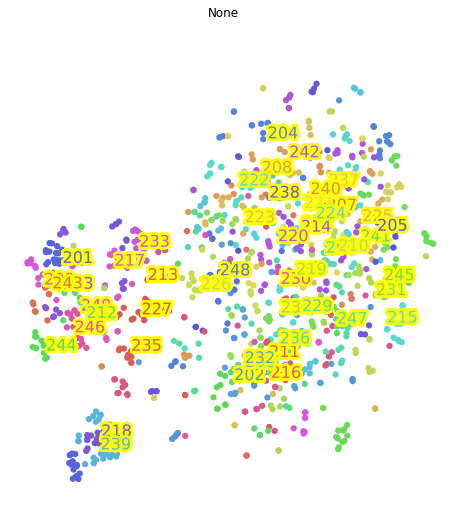

In [30]:
embs = embs_model.predict(X_val[0])
labels = Y_val[:, 0].astype(int)

embs_2d = TSNE().fit_transform(embs)
scatter(embs_2d, labels)

## Evaluation of model

* Get Embeddings
* Create a shallow neural network
* Train this network to decide if two embs is from the same person

In [61]:
embs_anchor_val = embs_model.predict(X_val[0])
embs_pos_val = embs_model.predict(X_val[1])
embs_neg_val = embs_model.predict(X_val[2])

embs_anchor_train = embs_model.predict(X_train[0])
embs_pos_train = embs_model.predict(X_train[1])
embs_neg_train = embs_model.predict(X_train[2])

In [58]:
pred_model_inp_a = Input(shape=(64,))
pred_model_inp_b = Input(shape=(64,))

pred_model = Dense(64, activation='relu')(tf.keras.layers.concatenate([pred_model_inp_a, pred_model_inp_b]))
pred_model = Dense(32, activation='relu')(pred_model)
pred_model_output = Dense(1, activation='sigmoid')(pred_model)

pred_model = Model(inputs=[pred_model_inp_a, pred_model_inp_b], outputs=pred_model_output)

pred_model.compile(loss='binary_crossentropy')
pred_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 128)          0           input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 64)           8256        concatenate_4[0][0]        

In [175]:
early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0,
                                                         verbose=1)
for _ in range(10):
    person_1 = []
    person_2 = []
    y_true = []
    for i in range(100000):
        person_idx = np.random.randint(embs_anchor_train.shape[0])
        person_1.append(embs_anchor_train[person_idx])
        
        if random.random()>.5: # same person
            person_2.append(embs_pos_train[person_idx])
            y_true.append(1)
        else: # different person
            person_2.append(embs_neg_train[person_idx])
            y_true.append(0)

    pred_model.fit([np.array(person_1), np.array(person_2)], np.array(y_true), 
                   epochs=5000, callbacks=[early_stopping])
    


Train on 100000 samples
Epoch 1/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.4496
Epoch 2/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.4410
Epoch 3/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.4366
Epoch 4/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.4307
Epoch 5/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.4283
Epoch 6/5000
100000/100000 [==============================] - 9s 91us/sample - loss: 0.4245
Epoch 7/5000
100000/100000 [==============================] - 9s 94us/sample - loss: 0.4216
Epoch 8/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.4188
Epoch 9/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.4162
Epoch 10/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.4131
Epoch 11/5000
100000/100000 [==========================

100000/100000 [==============================] - 9s 92us/sample - loss: 0.4177
Epoch 2/5000
100000/100000 [==============================] - 9s 91us/sample - loss: 0.4079
Epoch 3/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.4011
Epoch 4/5000
100000/100000 [==============================] - 9s 94us/sample - loss: 0.3987
Epoch 5/5000
100000/100000 [==============================] - 9s 94us/sample - loss: 0.3954
Epoch 6/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.3919
Epoch 7/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.3915
Epoch 8/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.3895
Epoch 9/5000
100000/100000 [==============================] - 9s 94us/sample - loss: 0.3868
Epoch 10/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.3860
Epoch 11/5000
100000/100000 [==============================] - 9s 91us/sample - loss: 0.3858

100000/100000 [==============================] - 9s 94us/sample - loss: 0.3736
Epoch 22/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.3735
Epoch 23/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.3724
Epoch 24/5000
100000/100000 [==============================] - 9s 91us/sample - loss: 0.3713
Epoch 25/5000
100000/100000 [==============================] - 9s 91us/sample - loss: 0.3717
Epoch 26/5000
100000/100000 [==============================] - 9s 91us/sample - loss: 0.3716
Epoch 27/5000
100000/100000 [==============================] - 9s 91us/sample - loss: 0.3704
Epoch 28/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.3705
Epoch 29/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.3697
Epoch 30/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.3697
Epoch 31/5000
100000/100000 [==============================] - 9s 92us/sample - loss

100000/100000 [==============================] - 9s 90us/sample - loss: 0.3741
Epoch 28/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.3740
Epoch 29/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.3729
Epoch 30/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.3727
Epoch 31/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.3729
Epoch 32/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.3746
Epoch 33/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.3713
Epoch 34/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.3721
Epoch 35/5000
100000/100000 [==============================] - 9s 90us/sample - loss: 0.3715
Epoch 36/5000
100000/100000 [==============================] - 9s 91us/sample - loss: 0.3712
Epoch 37/5000
100000/100000 [==============================] - 9s 92us/sample - loss

100000/100000 [==============================] - 9s 92us/sample - loss: 0.3701
Epoch 39/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.3700
Epoch 40/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.3696
Epoch 41/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.3691
Epoch 42/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.3691
Epoch 43/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.3685
Epoch 44/5000
100000/100000 [==============================] - 9s 91us/sample - loss: 0.3674
Epoch 45/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.3666
Epoch 46/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.3666
Epoch 47/5000
100000/100000 [==============================] - 9s 94us/sample - loss: 0.3668
Epoch 48/5000
100000/100000 [==============================] - 9s 93us/sample - loss

100000/100000 [==============================] - 9s 91us/sample - loss: 0.4019
Epoch 6/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.4005
Epoch 7/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.3970
Epoch 8/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.3959
Epoch 9/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.3957
Epoch 10/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.3921
Epoch 11/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.3907
Epoch 12/5000
100000/100000 [==============================] - 9s 91us/sample - loss: 0.3895
Epoch 13/5000
100000/100000 [==============================] - 9s 91us/sample - loss: 0.3906
Epoch 14/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.3887
Epoch 15/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.

100000/100000 [==============================] - 9s 92us/sample - loss: 0.3779
Epoch 00050: early stopping
Train on 100000 samples
Epoch 1/5000
100000/100000 [==============================] - 9s 94us/sample - loss: 0.4193
Epoch 2/5000
100000/100000 [==============================] - 10s 95us/sample - loss: 0.4113
Epoch 3/5000
100000/100000 [==============================] - 9s 91us/sample - loss: 0.4076
Epoch 4/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.4053
Epoch 5/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.3988
Epoch 6/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.3983
Epoch 7/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.3963
Epoch 8/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.3962
Epoch 9/5000
100000/100000 [==============================] - 9s 91us/sample - loss: 0.3932
Epoch 10/5000
100000/100000 [===========

In [240]:
person_1 = []
person_2 = []
y_true = []
for i in range(10000):
    person_idx = np.random.randint(embs_anchor_val.shape[0])
    person_1.append(embs_anchor_val[person_idx])

    if random.random()>.5: # same person
        person_2.append(embs_pos_val[person_idx])
        y_true.append(1)
    else: # different person
        person_2.append(embs_neg_val[person_idx])
        y_true.append(0)

y_pred = (pred_model.predict([np.array(person_1), np.array(person_2)]) > .5).flatten()
y_true = np.array(y_true) > .5
accuracy = np.sum(y_pred==y_true)/len(y_true)*100

print(accuracy)

71.38


In [241]:
pred_model.save('pred_model.h5')